In [1]:
import numpy as np
from scipy.integrate import odeint
from scipy.linalg import solve
from scipy.linalg import norm
from function_list import *
plt.rcParams['text.usetex'] = True

### Tutorial 2: Question 1
We seek to solve the following non-linear boundary value problem
\begin{equation}
y'' = 2y^3,\quad y'(1)=-\frac{1}{4},\quad y(4) + y'(4)=\frac{4}{25}
\end{equation}
using the Newton-Kantorovich method.

Expressing the boundary value problem as
\begin{equation}
F(y)=
\begin{cases}
y''-2y^3 = 0\\
y'(1) + \frac{1}{4}=0\\
y(4) + y'(4) -\frac{4}{25}=0
\end{cases}
\end{equation}

Then the Fréchet derivative is
\begin{equation}
F'z = 
\begin{cases}
\left[ \frac{d^2}{dx^2} - 6y^2\right]z = 0\\
z'(1) = 0 \\
z(4) + z'(4) = 0
\end{cases}
\end{equation}

Then the Newton-Kantorovich equation $F'z=-F$ is
\begin{align}
\left[\frac{d^2}{dx^2} - 6y^2\right]z &= - \left[y''-2y^3\right] \\
z'(1) &= -\left[y'(1) + \frac{1}{4} \right] \\
z(4) + z'(4) &= - \left[y(4) + y'(4) - \frac{4}{25} \right]
\end{align}

We now want to solve this system using finite differences. Let $h$ be the space step such that
\begin{equation}
h=\frac{b-a}{N}
\end{equation}
so there are $N+1$ points and $N$ spacings between those points of width $h$.

In [2]:
a, b = [1, 4] # [start point, end point]
N = 100 # number of points
h = (b-a)/N # space width
x = np.linspace(a, b, N+1) # space interval
tol = 10**(-6) # tolerance

Substituting the forward and centred finite differences into the Newton-Kantorovich equation 
\begin{align}
\frac{z_{j-1} - 2z_j + z_{j+1}}{h^2} - 6y_j^2z_j &= - \left[ \frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} - 2y_j^3\right]\\
\frac{-3z_1 + 4z_2 - z_3}{2h} &= - \left[ \frac{-3y_1 + 4y_2 - y_3}{2h} + \frac{1}{4} \right] \\
z_{N+1} + \frac{z_{N-1} - 4z_N + 3z_{N+1}}{2h} &= - \left[ y_{N+1} + \frac{y_{N-1} - 4y_N + 3y_{N+1}}{2h} - \frac{4}{25} \right]
\end{align}

Factoring the left hand side in terms of $z$
\begin{align}
z_{j-1}\left(\frac{1}{h^2}\right) + z_j\left( -\frac{2}{h^2} - 6y_j^2\right) + z_{j+1}\left(\frac{1}{h^2}\right) &= - \left[ \frac{y_{j-1} - 2y_j + y_{j+1}}{h^2} - 2y_j^3\right]\\
z_1\left(-\frac{3}{2h}\right) + z_2\left(\frac{4}{2h}\right) + z_3\left(-\frac{1}{2h}\right) &= - \left[ \frac{-3y_1 + 4y_2 - y_3}{2h} + \frac{1}{4} \right] \\
z_{N-1}\left( \frac{1}{2h}\right) + z_N\left(-\frac{4}{2h}\right) + z_{N+1} \left(1+\frac{3}{2h}\right) &= - \left[y_{N+1} + \frac{y_{N-1} - 4y_N + 3y_{N+1}}{2h} - \frac{4}{25}\right]
\end{align}

We can now express $F^{\,\prime}$ as a Jacobian matrix
\begin{equation*}
F^{\,\prime} = 
\begin{pmatrix}
-\frac{3}{2h} & \frac{4}{2h} & -\frac{1}{2h} & & \cdots & 0 \\
\frac{1}{h^2} & -\frac{2}{h^2} - 6y_j^2 & \frac{1}{h^2} & & \cdots & 0 \\
0 & \frac{1}{h^2} & -\frac{2}{h^2} - 6y_j^2 & \frac{1}{h^2}  & & 0 \\
\vdots & & & & & \vdots \\
0 & \cdots & & \frac{1}{h^2} & -\frac{2}{h^2} - 6y_N^2 & \frac{1}{h^2}\\
0 & 0 & \cdots & \frac{1}{2h} & -\frac{4}{2h} & 1 + \frac{3}{2h}
\end{pmatrix}
\end{equation*}


In [3]:
def jacobian_f(N, x, y, h):
    jacobian = np.zeros((N+1, N+1)) # creates an N+1 by N+1 dimension array
    
    jacobian[(0, 0)] = -3/(2*h) 
    jacobian[(0, 1)] = 4/(2*h)
    jacobian[(0, 2)] = -1/(2*h)
    
    jacobian[(N, N)] = 1+3/(2*h)
    jacobian[(N, N-1)] = -4/(2*h)
    jacobian[(N, N-2)] = 1/(2*h)
    
    diag_1 = 1/(h**2)
    diag_2 = []
    diag_3 = 1/(h**2)

    for i in range(1, N):
        diag_2.append(-2/(h**2) - 6*y[i]**2)

    np.fill_diagonal(jacobian[1:, :N - 1], diag_1)
    np.fill_diagonal(jacobian[1:N, 1:N], diag_2)
    np.fill_diagonal(jacobian[1:N + 1, 2:N + 1], diag_3)

    return jacobian

Similarly, we can express $z$ and $-F$ as vectors to solve $F'z=-F$
\begin{equation*}
\vec{z}=
\begin{pmatrix}
z_1 \\
z_2 \\
z_3 \\
\vdots \\
z_{N+1}
\end{pmatrix},\quad
-\vec{F}=
\begin{pmatrix}
- \frac{-3y_1 + 4y_2 - y_3}{2h} - \frac{1}{4} \\
- \frac{y_{1} - 2y_2 + y_{3}}{h^2} + 2y_2^3 \\
- \frac{y_{2} - 2y_3 + y_{4}}{h^2} + 2y_3^3 \\
\vdots \\
- y_{N+1} - \frac{y_{N-1} - 4y_N + 3y_{N+1}}{2h} + \frac{4}{25}
\end{pmatrix}
\end{equation*}


In [4]:
def vec_f(N, x, y, h):
    A = np.zeros(N + 1)
    A[0] = -(-3 * y[0] + 4 * y[1] - y[2])/(2*h) - 1/4
    A[N] = -y[N] - (y[N-2] - 4*y[N-1] + 3*y[N])/(2*h) + 4/25

    for i in range(1, N):
        A[i] = -(y[i-1] - 2*y[i] + y[i+1])/(h**2) + 2*y[i]**3

    return A

We can now create a while loop to iteratively solve for $\vec{y}$ with corrections $\vec{z}$

In [5]:
def newton_kantorovich_method_f(N, x, y, h, tol):
    n_iterations = 0
    A = vec_f(N, x, y, h)

    while norm(A) > tol and n_iterations < 100:
        jacobian = jacobian_f(N, x, y, h)
        z = solve(jacobian, A)
        y = y + z
        A = vec_f(N, x, y, h)
        n_iterations = n_iterations + 1

    return y, n_iterations

We can now test this using the values obtained from the shooting method as the ansatz for $y$ 

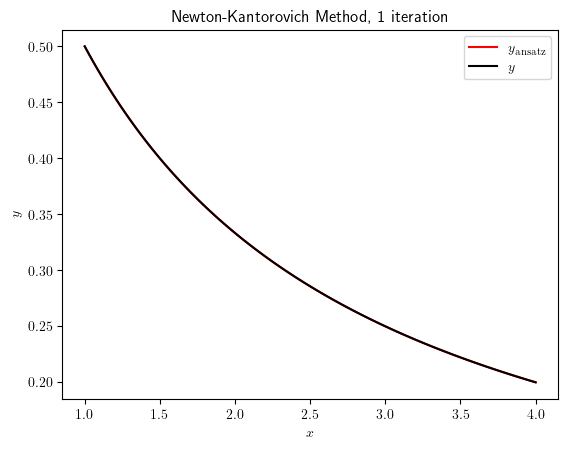

In [6]:
y_ansatz = shooting_method_f([0.49, 0.51], x, tol)[0]
y, n_iterations = newton_kantorovich_method_f(N, x, y_ansatz, h, tol)
plot_f(x, y_ansatz, y, n_iterations)

We can also test this using a different ansatz
\begin{equation}
y(x) = \frac{1}{1+x^2}
\end{equation}

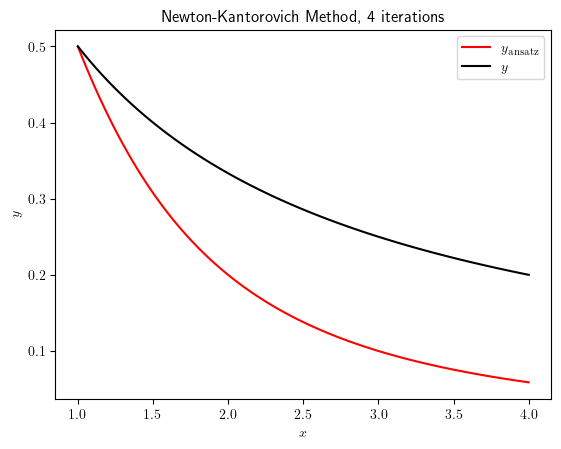

In [7]:
y_ansatz = 1/(1+x**2)
y, n_iterations = newton_kantorovich_method_f(N, x, y_ansatz, h, tol)
plot_f(x, y_ansatz, y, n_iterations)

We can also test a poor choice of ansatz
\begin{equation}
y(x)=\sin(x)
\end{equation}

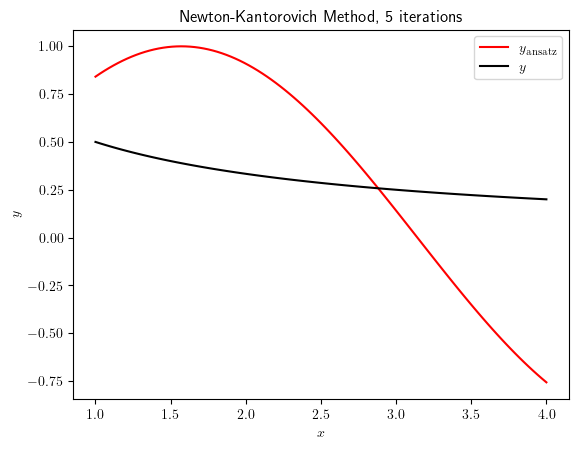

In [8]:
y_ansatz = np.sin(x)
y, n_iterations = newton_kantorovich_method_f(N, x, y_ansatz, h, tol)
plot_f(x, y_ansatz, y, n_iterations)